In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
class MeanRevBacktester():
    ''' Class for the vectorized backtesting of Bollinger Bands-based trading strategies.
    '''
    
    def __init__(self, symbol, SMA, dev, start, end, tc):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA: int
            moving window in bars (e.g. days) for SMA
        dev: int
            distance for Lower/Upper Bands in Standard Deviation units
        start: str
            start date for data import
        end: str
            end date for data import
        tc: float
            proportional transaction/trading costs per trade
        '''
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        rep = "MeanRevBacktester(symbol = {}, SMA = {}, dev = {}, start = {}, end = {})"
        return rep.format(self.symbol, self.SMA, self.dev, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data from intraday_pairs.csv (source can be changed).
        '''
        raw = pd.read_csv("intraday_pairs.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        self.data = raw
        
    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std() * self.dev
        data["Upper"] = data["SMA"] + data["price"].rolling(self.SMA).std() * self.dev
        self.data = data
        
    def set_parameters(self, SMA = None, dev = None):
        ''' Updates parameters (SMA, dev) and the prepared dataset.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
    def test_strategy(self):
        ''' Backtests the Bollinger Bands-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA = {} | dev = {} | TC = {}".format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))     
   
    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds the optimal strategy (global maximum) given the Bollinger Bands parameter ranges.

        Parameters
        ----------
        SMA_range, dev_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        combinations = list(product(range(*SMA_range), range(*dev_range)))
        
        # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA", "dev"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf

In [4]:
df = pd.read_csv("intraday_pairs.csv", parse_dates = ["time"], index_col = "time")
df

,EURUSD,GBPUSD,EURAUD
time,,,
2018-01-01 22:00:00+00:00,1.201205,1.351705,1.533390
2018-01-02 04:00:00+00:00,1.207055,1.354830,1.540480
2018-01-02 10:00:00+00:00,1.204440,1.357860,1.537980
2018-01-02 16:00:00+00:00,1.205800,1.359180,1.540185
2018-01-02 22:00:00+00:00,1.204690,1.359530,1.542225
...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,1.311810,1.602420
2019-12-30 04:00:00+00:00,1.119940,1.311880,1.600800
2019-12-30 10:00:00+00:00,1.120095,1.311465,1.601165


In [5]:
ptc = 0.00007

In [6]:
tester = MeanRevBacktester("EURUSD", 30, 2, "2018-01-01", "2019-12-31", ptc)

In [7]:
tester

MeanRevBacktester(symbol = EURUSD, SMA = 30, dev = 2, start = 2018-01-01, end = 2019-12-31)

In [8]:
tester.test_strategy()

(1.069792, 0.132076)

In [9]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,
2018-01-11 10:00:00+00:00,1.204915,0.008455,1.200628,1.190841,1.210415,0.004287,0.0,0.000000,0.0,1.008491,1.000000
2018-01-11 16:00:00+00:00,1.203205,-0.001420,1.200500,1.190964,1.210035,0.002705,0.0,-0.000000,0.0,1.007060,1.000000
2018-01-11 22:00:00+00:00,1.205165,0.001628,1.200524,1.190943,1.210104,0.004641,0.0,0.000000,0.0,1.008700,1.000000
2018-01-12 04:00:00+00:00,1.212530,0.006093,1.200748,1.190374,1.211122,0.011782,-1.0,-0.000070,1.0,1.014865,0.999930
2018-01-12 10:00:00+00:00,1.214820,0.001887,1.201086,1.189583,1.212589,0.013734,-1.0,-0.001887,0.0,1.016781,0.998045
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,1.111391,1.105215,1.117567,0.008529,-1.0,-0.002092,0.0,0.937352,1.070207
2019-12-30 04:00:00+00:00,1.119940,0.000018,1.111553,1.104754,1.118352,0.008387,-1.0,-0.000018,0.0,0.937369,1.070188
2019-12-30 10:00:00+00:00,1.120095,0.000138,1.111777,1.104318,1.119235,0.008318,-1.0,-0.000138,0.0,0.937498,1.070040


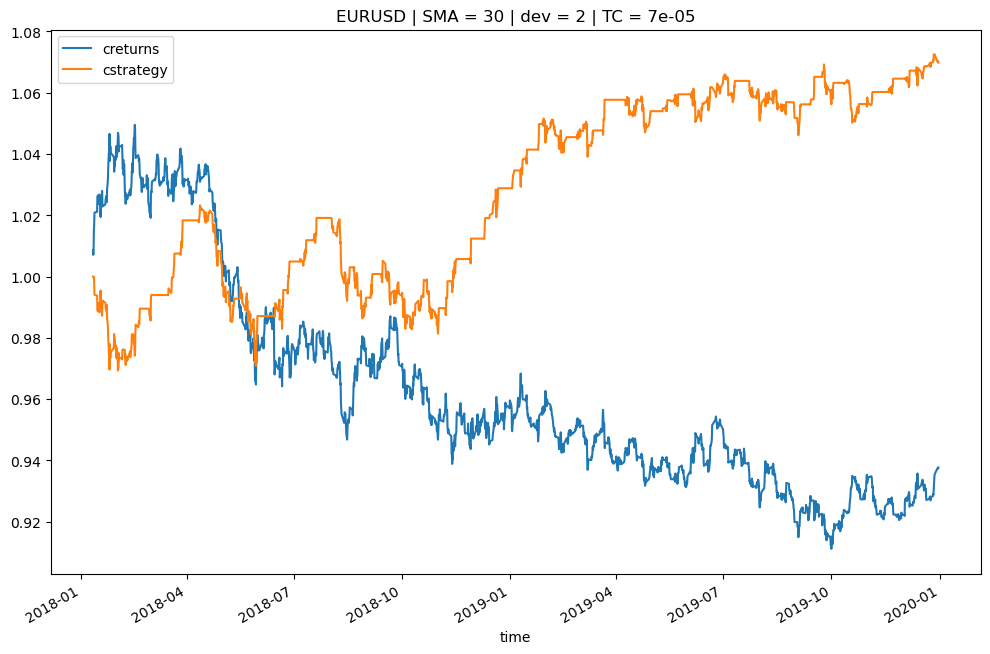

In [10]:
tester.plot_results()

In [11]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

((58, 1), 1.238111)

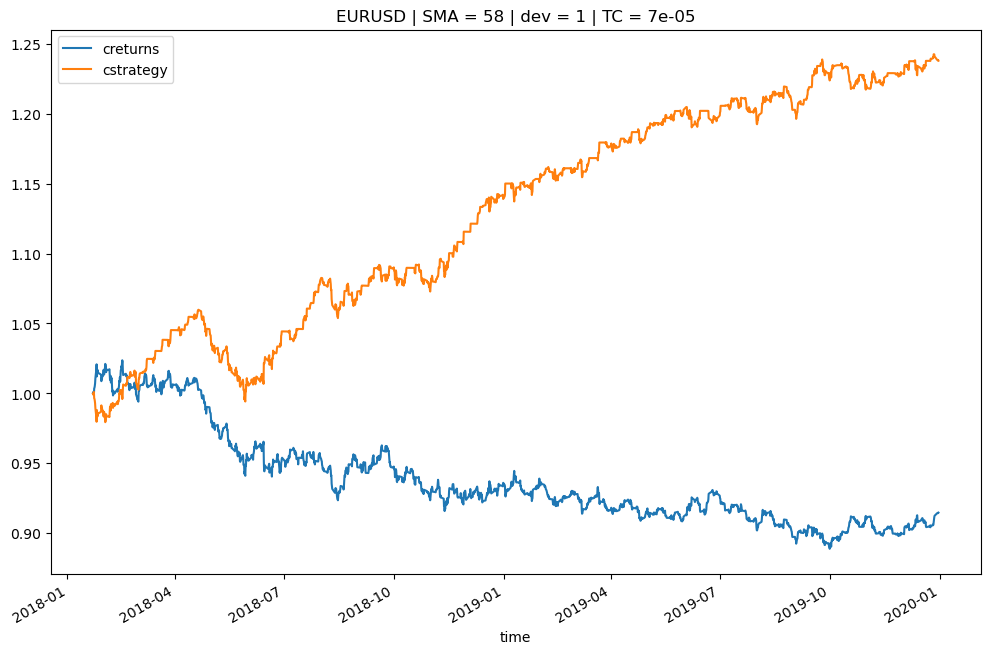

In [12]:
tester.plot_results()

In [13]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,
2018-01-22 10:00:00+00:00,1.225370,0.000343,1.210748,1.198848,1.222648,0.014622,-1.0,-0.000343,0.0,1.000343,0.999657
2018-01-22 16:00:00+00:00,1.226135,0.000624,1.211077,1.199018,1.223136,0.015058,-1.0,-0.000624,0.0,1.000967,0.999034
2018-01-22 22:00:00+00:00,1.225780,-0.000290,1.211445,1.199267,1.223623,0.014335,-1.0,0.000290,0.0,1.000678,0.999323
2018-01-23 04:00:00+00:00,1.223765,-0.001645,1.211755,1.199495,1.224015,0.012010,-1.0,0.001645,0.0,0.999033,1.000968
2018-01-23 10:00:00+00:00,1.229295,0.004509,1.212179,1.199743,1.224614,0.017116,-1.0,-0.004509,0.0,1.003547,0.996465
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,1.111350,1.107982,1.114718,0.008570,-1.0,-0.002092,0.0,0.914258,1.238592
2019-12-30 04:00:00+00:00,1.119940,0.000018,1.111591,1.108116,1.115065,0.008349,-1.0,-0.000018,0.0,0.914274,1.238569
2019-12-30 10:00:00+00:00,1.120095,0.000138,1.111843,1.108291,1.115395,0.008252,-1.0,-0.000138,0.0,0.914401,1.238398


In [14]:
tester.results_overview

,SMA,dev,performance
0,25,1,0.995746
1,25,2,1.050603
2,25,3,1.039728
3,25,4,1.000000
4,26,1,0.995291
...,...,...,...
295,98,4,1.000000
296,99,1,1.166676
297,99,2,1.168985
298,99,3,1.018584


In [15]:
tester.results_overview.nlargest(10, "performance")

,SMA,dev,performance
132,58,1,1.238111
136,59,1,1.231034
148,62,1,1.230248
152,63,1,1.229423
128,57,1,1.228237
144,61,1,1.225364
116,54,1,1.223270
156,64,1,1.223054
140,60,1,1.222840
172,68,1,1.217669


In [16]:
tester.results_overview.nsmallest(10, "performance")

,SMA,dev,performance
4,26,1,0.995291
0,25,1,0.995746
30,32,3,0.999410
3,25,4,1.000000
7,26,4,1.000000
11,27,4,1.000000
15,28,4,1.000000
19,29,4,1.000000
23,30,4,1.000000
27,31,4,1.000000
